In [28]:
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.image as mpimg
from scipy.ndimage.filters import convolve
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
import matplotlib.lines as mlines

In [29]:
def Canny_Detection(img):
    def gaussian_kernel(size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g

    def sobel_filters(img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = convolve(img, Kx)
        Iy = convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)

        return (G, theta)    

    def non_max_suppression(img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255


                    if (0 <= angle[i,j] < 2) or (178 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0

                except IndexError as e:
                    pass

        return Z

    def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09): #High 0.09 Try changing it around

        highThreshold = img.max() * highThresholdRatio;
        lowThreshold = highThreshold * lowThresholdRatio;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(25)
        strong = np.int32(255)

        strong_i, strong_j = np.where(img >= highThreshold)
        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return res

    def hysteresis(img, weak=25, strong=255):
        M, N = img.shape  
        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass
        return img
    blurred = convolve(img,gaussian_kernel(15))
    G,theta = sobel_filters(blurred)
    suppressed = non_max_suppression(G,theta)
    thresh = threshold(suppressed)
    final = hysteresis(thresh)
    
    return final;
    

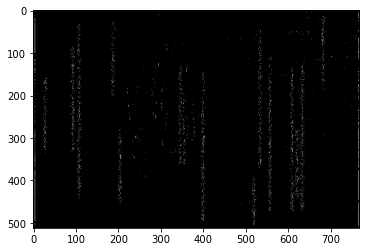

In [30]:
img_name = "synthetic1.png" #"test.jpg"
img = mpimg.imread(img_name)
if img_name[-3:] == "png":
    img = img*255
    img = img.astype(int)
    
final= Canny_Detection(img)

plt.imshow(final,cmap = "gray")
mpimg.imsave("edge1.jpg",final,cmap = "gray")

In [31]:
def masking(a):
    def voting(edge):
        H, W = edge.shape

        drho = 1
        dtheta = 1


        rho_max = np.ceil(np.sqrt(H ** 2 + W ** 2)).astype(int)
        hough = np.zeros((rho_max, 180), dtype=int)
        ind = np.where(edge == 255)

        for y, x in zip(ind[0], ind[1]):
                for theta in range(0, 180, dtheta): #0,180
                        t = np.pi / 180 * theta
                        rho = int(x * np.cos(t) + y * np.sin(t))
                        hough[rho, theta] += 1

        out = hough.astype(np.uint8)

        return out


    def non_maximum_suppression(hough):
        rho_max, _ = hough.shape
        for y in range(rho_max):
            for x in range(180):
                # get 8 nearest neighbor
                x1 = max(x-1, 0)
                x2 = min(x+2, 180)
                y1 = max(y-1, 0)
                y2 = min(y+2, rho_max-1)
                if np.max(hough[y1:y2, x1:x2]) == hough[y,x] and hough[y, x] != 0:
                    pass
                else:
                    hough[y,x] = 0

        return hough

    def inverse_hough(hough, img):
        H, W = img.shape
        rho_max, _ = hough.shape

        out = np.zeros((H,W,3))
        out[:,:,0] = img.copy()
        out[:,:,1] = img.copy()
        out[:,:,2] = img.copy()

        ind_x = np.argsort(hough.ravel())[::-1][:2000] #20
        ind_y = ind_x.copy()
        thetas = ind_x % 180
        rhos = ind_y // 180
        scratch_ind = []

        # each theta and rho
        for theta, rho in zip(thetas, rhos):
            if theta == 0:
                t = np.pi / 180. * theta
                #hough -> (x,y)
                for y in range(H):
                    if np.cos(t):
                        x = - (np.sin(t) / np.cos(t)) * y + (rho) / np.cos(t)
                        x = int(x)
                        if x >= W or x < 0:
                            continue
                        out[y, x] = [0,0,255]
                        scratch_ind.append(x)

        out = out.astype(np.uint8)

        return out,scratch_ind
    votes = voting(final)
    hough = non_maximum_suppression(votes)
    hough,ind = inverse_hough(hough, img)
    ind = set(ind)
    return hough, ind

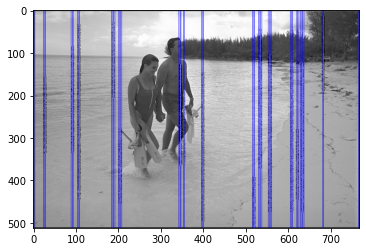

In [32]:
hough,indecs= masking(final)
hough = hough.astype(np.uint8)
plt.imshow(hough,cmap = "gray")
mpimg.imsave("lines1.jpg",hough)

In [33]:
def create_lines(img,edge,ind):
    h,w = img.shape
    result = np.zeros((h,w))
    
    for c in ind:
        for r in range(h):
            if edge[r,c] == 255:
                first = r
                break
        for r in range(h-1,0,-1):
            if edge[r,c] == 255:
                last = r
                break
        for r in range(first,last):
            result[r,c] = 255
            #hoirzpntal extension
            result[r,c+1] = 255
            result[r,c-1] = 255
            
            
    return result
            
def mask_over(img,template):
    h,w = img.shape
    result = np.zeros((h,w,3))
    result[:,:,0] = img.copy()
    result[:,:,1] = img.copy()
    result[:,:,2] = img.copy()
    
    for i in range(h):
        for j in range(w):
            if template[i,j] == 255:
                result[i,j,:] = [0,255,0]
    return result
    

    

(512, 768)


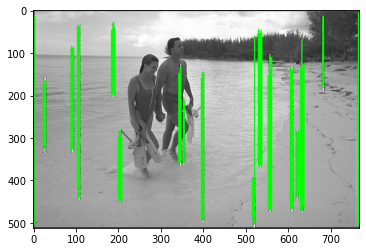

In [34]:
template = create_lines(img,final,indecs)
mask = mask_over(img,template)

mask = mask.astype(np.uint8)
plt.imshow(mask,cmap = "gray")
mpimg.imsave("mask.jpg",mask)
print(template.shape)

In [35]:
def median_filtering(img, ind, edge, max_size = 11):
    result = img.copy()
    pad = np.pad(img,max_size)
    height,width = img.shape
    s_xy = 1
    
    for i in range(height):
        for j in range(width):
            if edge[i,j] == 255:
                value = adaptive_median(ind,pad,i,j,s_xy,max_size)
                result[i,j] = value
            
            else:
                result[i,j] = img[i,j]     
                
    return result

def buid_region(ind,pad,i,j,s_xy,max_size):
    range_h = range(j-s_xy, j+s_xy+1)
    region = []
    for c in range_h:
        if (c in ind or c+1 in ind or c-1 in ind):
            continue
        region.append(pad[i+max_size,c+max_size]) 
    return region

def adaptive_median(ind,pad,i,j,s_xy,max_size):
    region = buid_region(ind,pad,i,j,s_xy,max_size)
    if region == []:
        s_xy += 1
        return adaptive_median(ind,pad,i,j,s_xy,max_size)
    z_xy = pad[i+max_size, j+max_size]
    z_min = np.min(region)
    z_max = np.max(region)
    z_med = np.median(region)

    A1 = z_med - z_min
    A2 = z_med - z_max

    if (A1>0 and A2<0):
        B1 = z_xy - z_min
        B2 = z_xy - z_max

        if (B1>0 and B2<0):
            return z_xy
        else:
            return z_med
    else:
        s_xy += 1
        if(s_xy >= max_size):
            return z_xy
        return adaptive_median(ind,pad,i,j,s_xy,max_size)

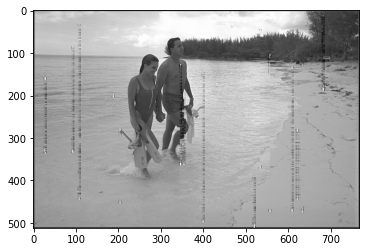

In [36]:
corrected = median_filtering(img, indecs, template, max_size=20)

corrected = corrected.astype(np.uint8)
plt.imshow(corrected,cmap = "gray")
mpimg.imsave("corrected.jpg",corrected, cmap = "gray")